In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from load_img.baseimage import PETImage, normalize
from scipy.integrate import odeint
from kmeans_segmentation import pca_kmeans_segmentation, fourier_kmeans_segmentation, apply_masks
from utility_functions import sparsifyDynamics, poolData
from matplotlib import style
style.use('dark_background')

#### Some helpful functions

In [6]:
def disp_segment(seg, view_ax = 'y', col_t = 'sum', col_v = 'sum', figsize=(18, 16)):
    ax_ix = {'z':0,'y':1,'x':2,'t':3}[view_ax]
    
    frame = getattr(seg,col_t)(axis=3)
    
    img = getattr(frame,col_v)(axis=ax_ix)
    
    fig = plt.figure(figsize=figsize)
    plt.imshow(img,cmap='gray')
    plt.show()
    

    
# def find_opt_x0(dynamic_fn, xdf):
    
    

    

#### Data from File

In [77]:
data_dir = 'data'
pet_files = [f for f in os.listdir(data_dir) if f.endswith('.pet.img') and not f.startswith('.')]
fname = pet_files[0]
fpath = os.path.join(data_dir,fname)
my_img = PETImage(filepath=fpath)
my_img.load_image()

File dimensions: (128,128,159,40)
Reading image data...


## Segment Image

#### Fourier Segmentation

Clustering image voxels...
Created 20 masks of image


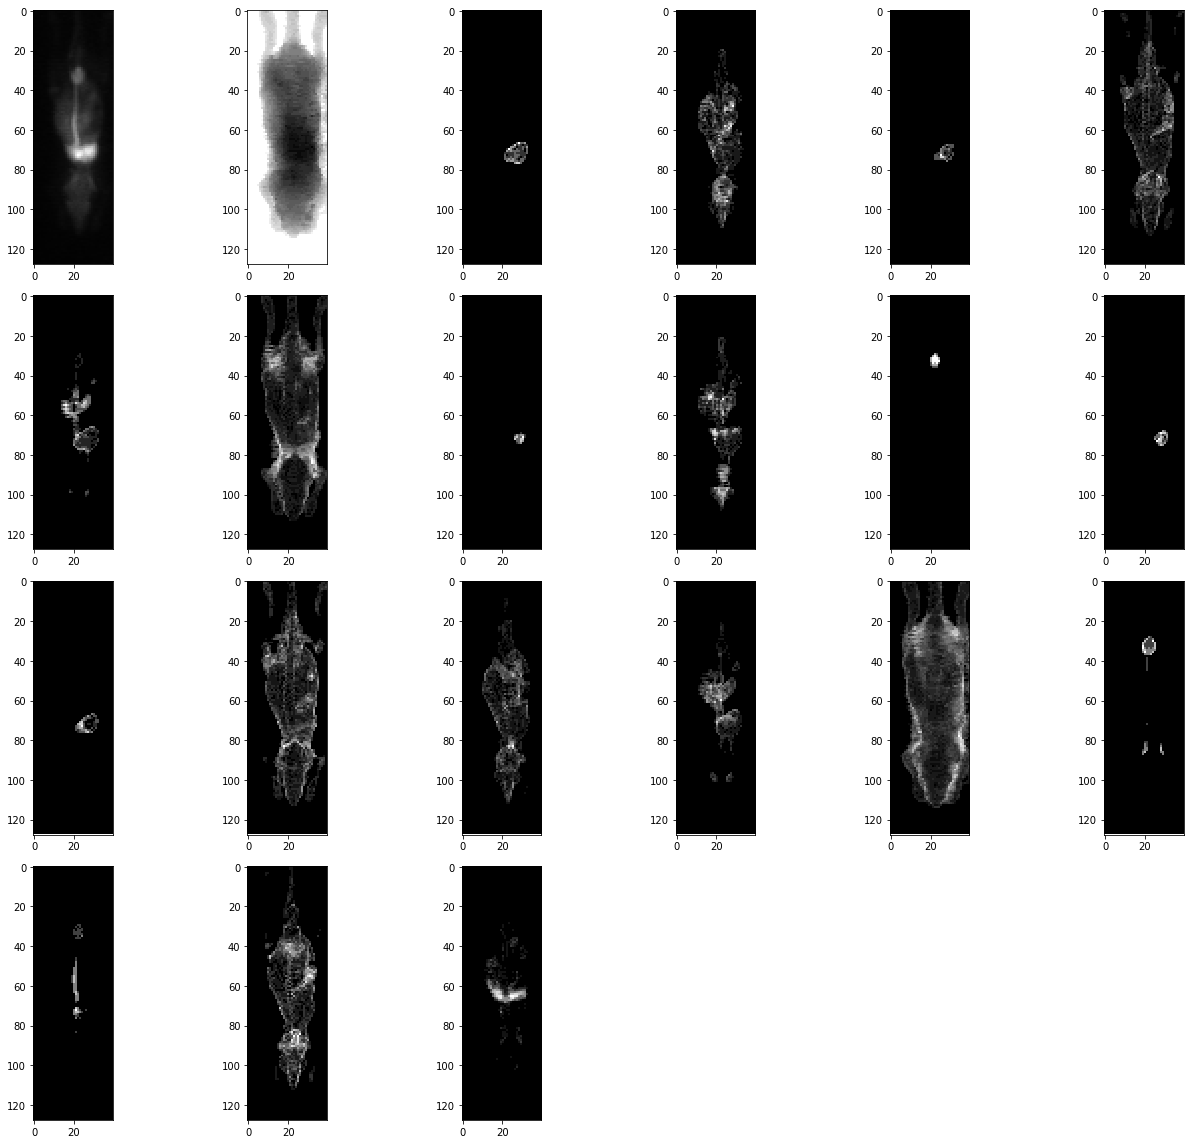

In [8]:
Ns = my_img.img_data.shape

# select the middle z=Ws[0],y=Ws[1],x=Ws[2] prism of each frame
Ws = (128,60,40)
roi_lims = [(int((N-W)/2),int((N+W)/2)) for N,W in zip(Ns,Ws)]

# select options for segmentation and run segmentation
print('Clustering image voxels...')
options = {
    'roi_lims' : roi_lims,
    'plot' : True,
    'fig_size' : (18, 16),
    'nfeatures' : 6,
    'nclusters' : 20
    }
masks, roi = fourier_kmeans_segmentation(my_img,**options)



#### Time series segmentation

Clustering image voxels...
Created 20 masks of image


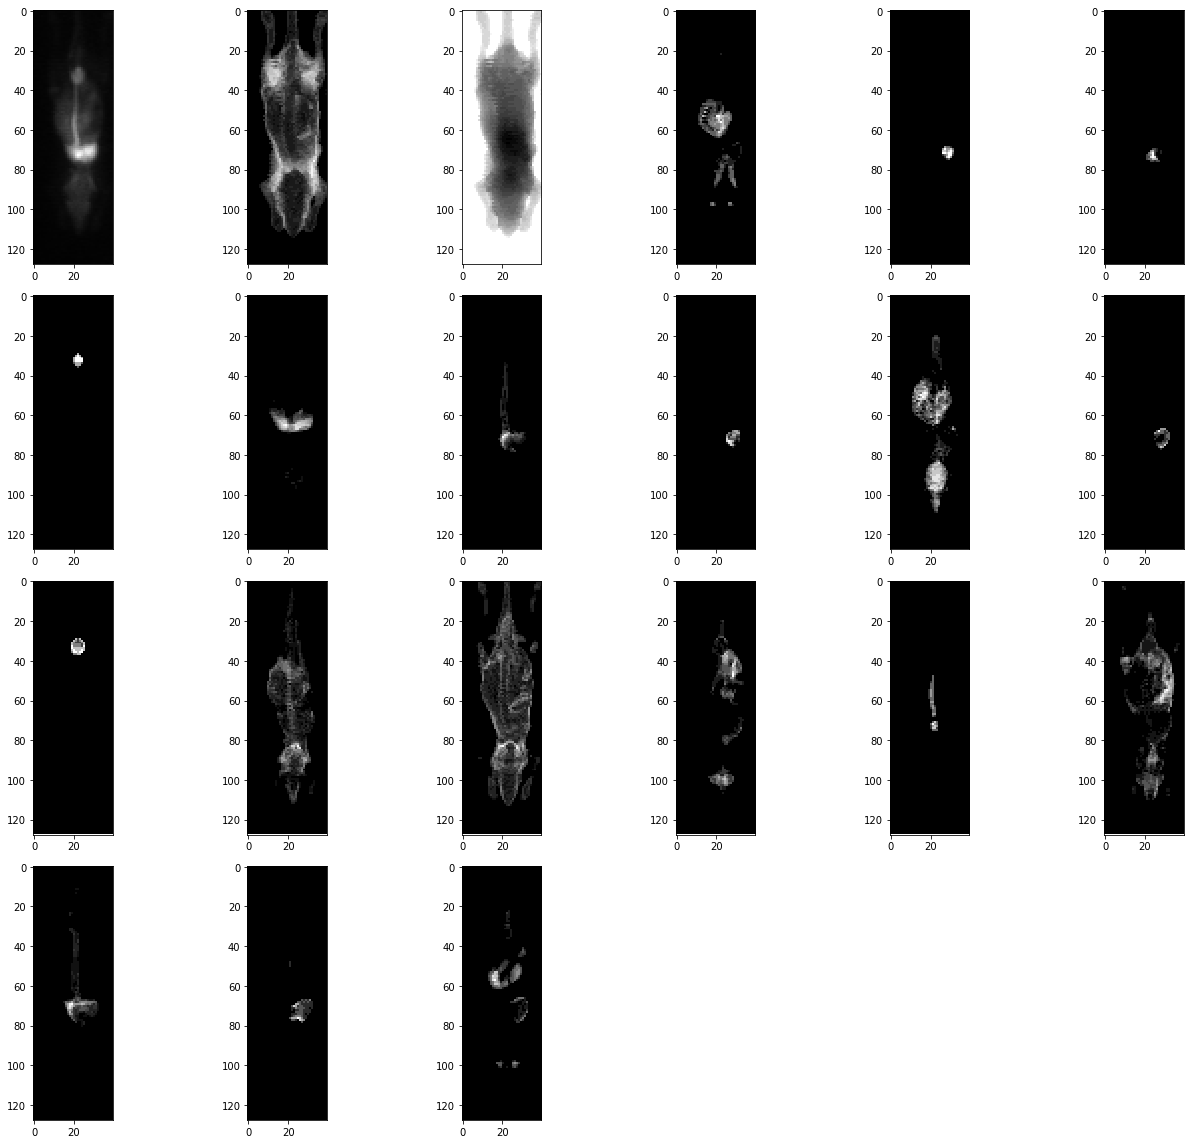

In [78]:
Ns = my_img.img_data.shape

# select the middle z=Ws[0],y=Ws[1],x=Ws[2] prism of each frame
Ws = (128,60,40)
roi_lims = [(int((N-W)/2),int((N+W)/2)) for N,W in zip(Ns,Ws)]

# select options for segmentation and run segmentation
print('Clustering image voxels...')
options = {
    'roi_lims' : roi_lims,
    'plot' : True,
    'fig_size' : (18, 16),
    'nfeatures' : 6,
    'nclusters' : 20
    }
masks, roi = pca_kmeans_segmentation(my_img,**options)

# done with original image data
my_img.unload_image()

#### apply masks to original ROI

In [80]:
# done with original image data
my_img.unload_image()

new_rois = apply_masks(masks,roi)

#### plot total intensity of each segment

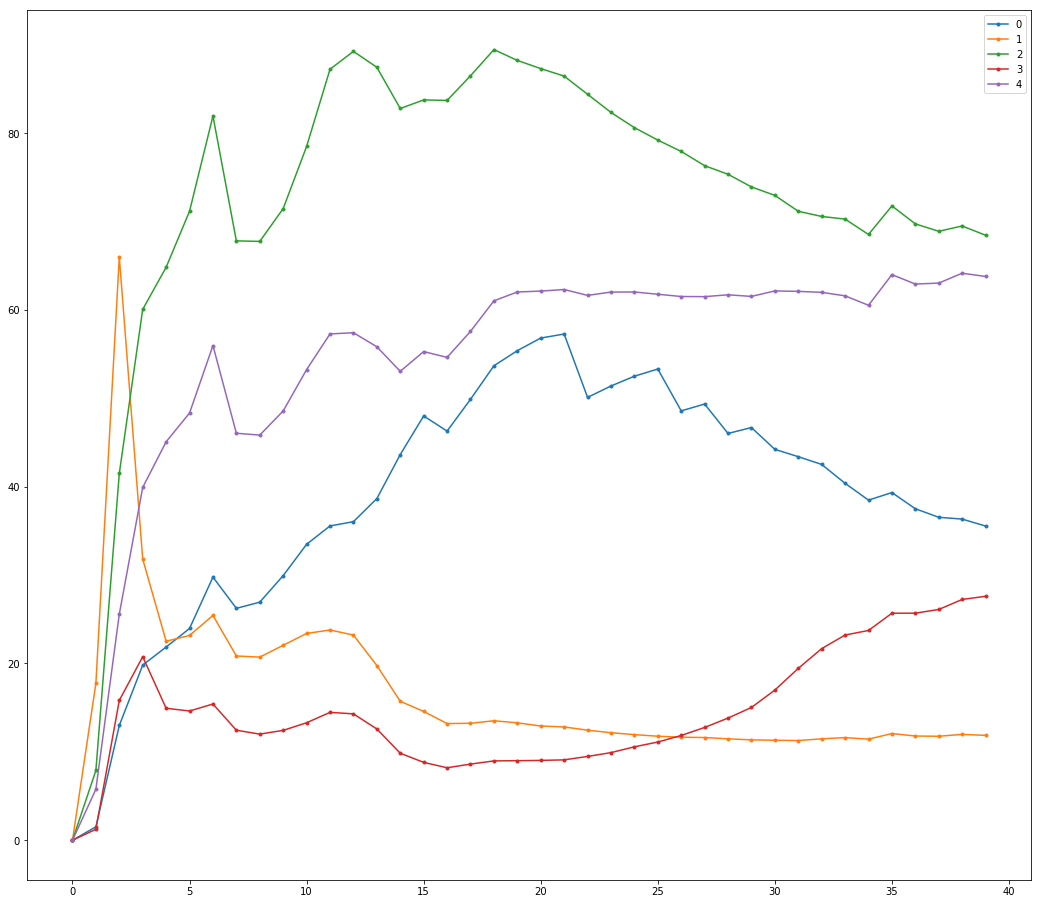

In [64]:
intensity_curves  = [mroi.reshape(Ws[0]*Ws[1]*Ws[2],Ns[-1]).sum(axis=0) for mroi in new_rois]
df = pd.DataFrame(data=np.stack(intensity_curves).T)
df.plot(figsize=(18, 16),marker='.')

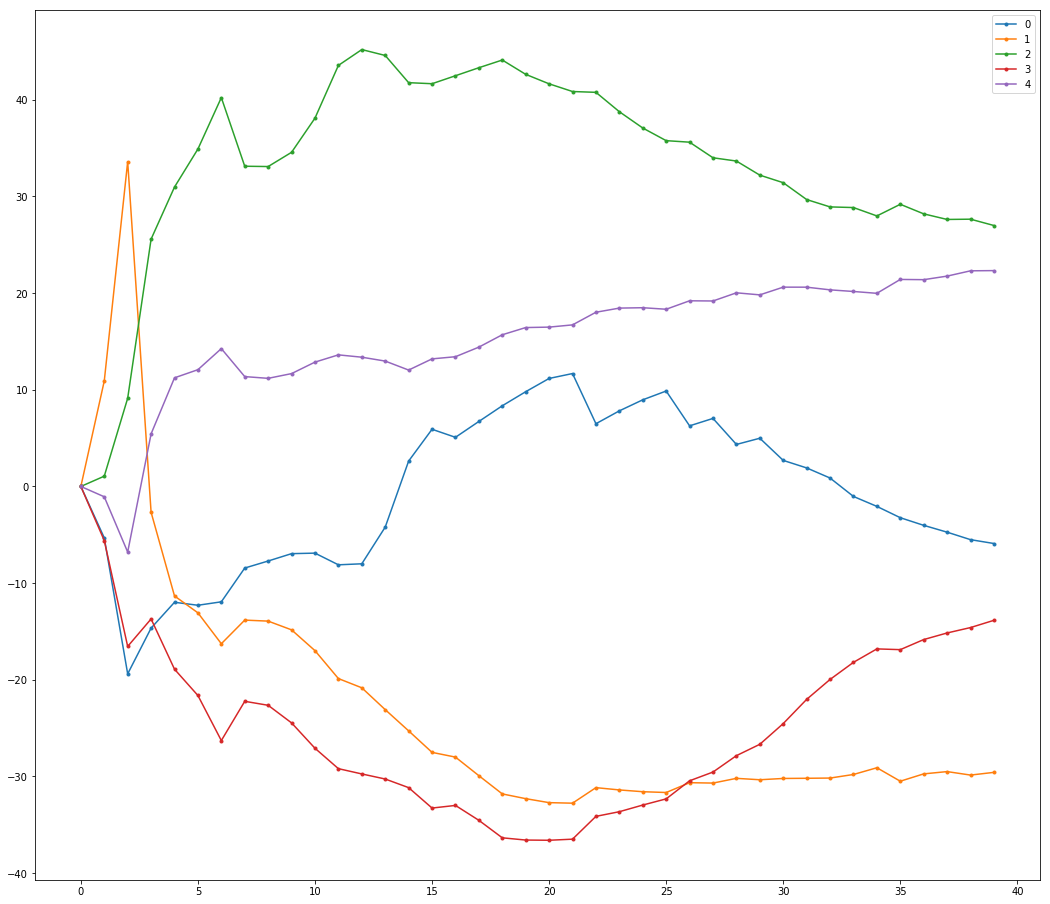

In [65]:
# subtract mean at each time point from corresponding intensities
sdf = df.subtract(df.mean(axis=1),axis=0)
sdf.plot(figsize=(18, 16),marker='.')

#### Pick some clusters

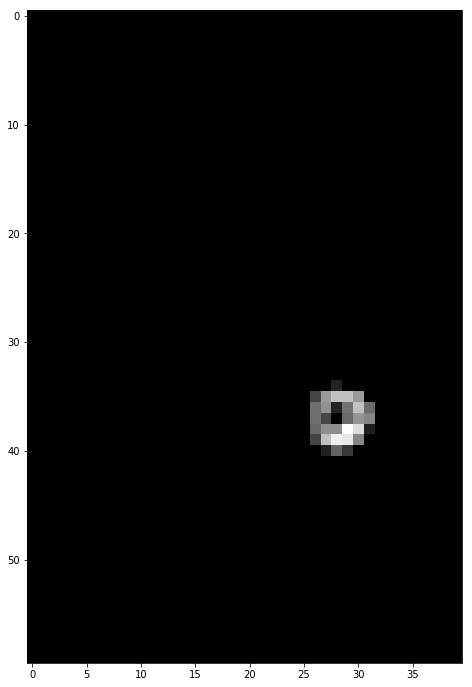

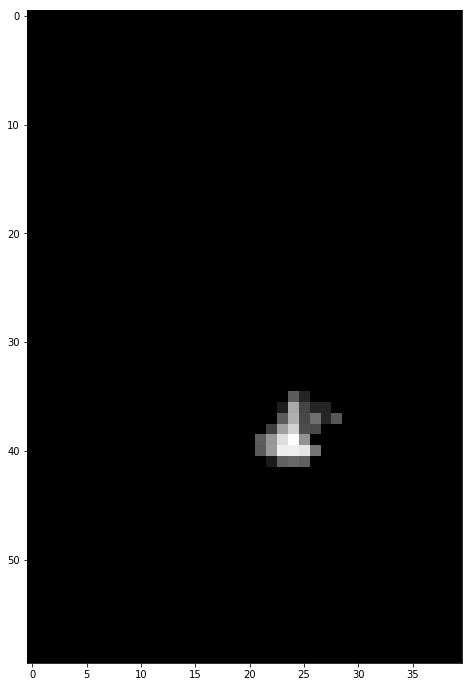

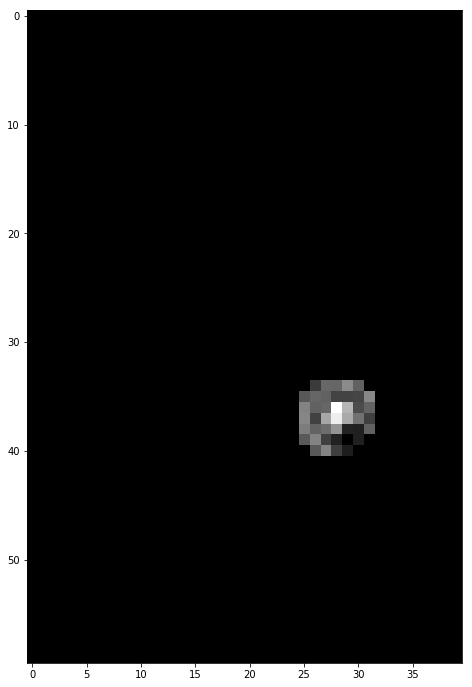

In [81]:
disp_segment(new_rois[3], figsize=(14,12),view_ax='z')
disp_segment(new_rois[4], figsize=(14,12),view_ax='z')
disp_segment(new_rois[8], figsize=(14,12),view_ax='z')

#### Get cluster data as df    

In [82]:
# since we lose a row in diff step,
# just use first N rows of df


# dont use first few rows with no tracer
N = 40
n_start = 3
npts = N-n_start-1
X = df[n_start:-1]
X_dot = df.diff()[n_start+1:]

In [83]:
X_dot.shape

(36, 5)

#### Get subdf with just the ixs of the clusters we want to analyze

In [84]:
ixs = [1,2,3,4]
tX = X[ixs].reset_index(drop=True)
tX_dot = X_dot[ixs].reset_index(drop=True)
frame_durations = my_img.params.frame_duration[n_start:-1]
tX_dot = tX_dot.div(frame_durations,axis=0)   # divide out frame duration
tX.shape

(36, 4)

#### Prepare SINDy

In [85]:
n,nVars = tX.shape

cols = ['x{}'.format(i+1) for i in range(nVars)]
tX.columns = cols
dot_labels = pd.Index([s + 'dot' for s in cols])

polyorder = 2
lam = 0.001
usesine = 0

Theta = pd.DataFrame()
Theta = poolData(tX,nVars, polyorder, usesine)

#### Run SINDy

In [86]:
Xhat_df = sparsifyDynamics(Theta,tX_dot,lam)
Xhat_df = Xhat_df.set_index(dot_labels)
print(Xhat_df.head())


         0        x1       x2        x3        x4  (x1, x1)  (x1, x2)  \
x1dot  0.0  0.009452 -0.04452  0.000000 -0.056422 -0.010320       0.0   
x2dot  0.0  0.833881 -0.00000  0.022445  0.000000 -0.008246      -0.0   
x3dot  0.0  0.000000 -0.00000  0.000000 -0.000000 -0.001717       0.0   
x4dot  0.0  0.415684  0.00000  0.022856 -0.000734 -0.000000       0.0   

       (x1, x3)  (x1, x4)  (x2, x2)  (x2, x3)  (x2, x4)  (x3, x3)  (x3, x4)  \
x1dot -0.004975  0.007312 -0.000000       0.0 -0.000437  0.000081  0.000000   
x2dot  0.000000 -0.012546  0.000000       0.0  0.000072 -0.000000 -0.000000   
x3dot -0.008075  0.002919 -0.000030       0.0 -0.000488  0.000382  0.000796   
x4dot  0.000000 -0.010066  0.000141       0.0  0.000000  0.000000  0.000000   

       (x4, x4)  
x1dot -0.000000  
x2dot  0.000003  
x3dot -0.000000  
x4dot -0.000000  


/Users/frankenstein/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Test recovered dynamics

In [87]:

dynamic_fn = lambda x,t: np.squeeze(np.matmul(
        Xhat_df.as_matrix(),
        poolData(pd.DataFrame(x).T,nVars, polyorder, usesine).values.T
))

t_span = np.cumsum(frame_durations)

# how to choose x0?
x0 = tX.iloc[0].values


dynamic_fn(x0,3)
X_s = odeint(dynamic_fn,x0,t_span)

/Users/frankenstein/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


###### Plot phase curves for simulated 

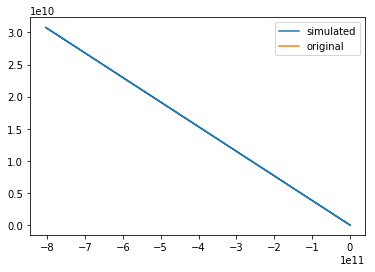

In [88]:
xa,xb = 1,3

plt.plot(X_s[:,xa],X_s[:,xb])
tXmat = tX.as_matrix()
plt.plot(tXmat[:,xa],tXmat[:,xb])
plt.legend(['simulated','original'])
plt.show()

###### Compare single var over time

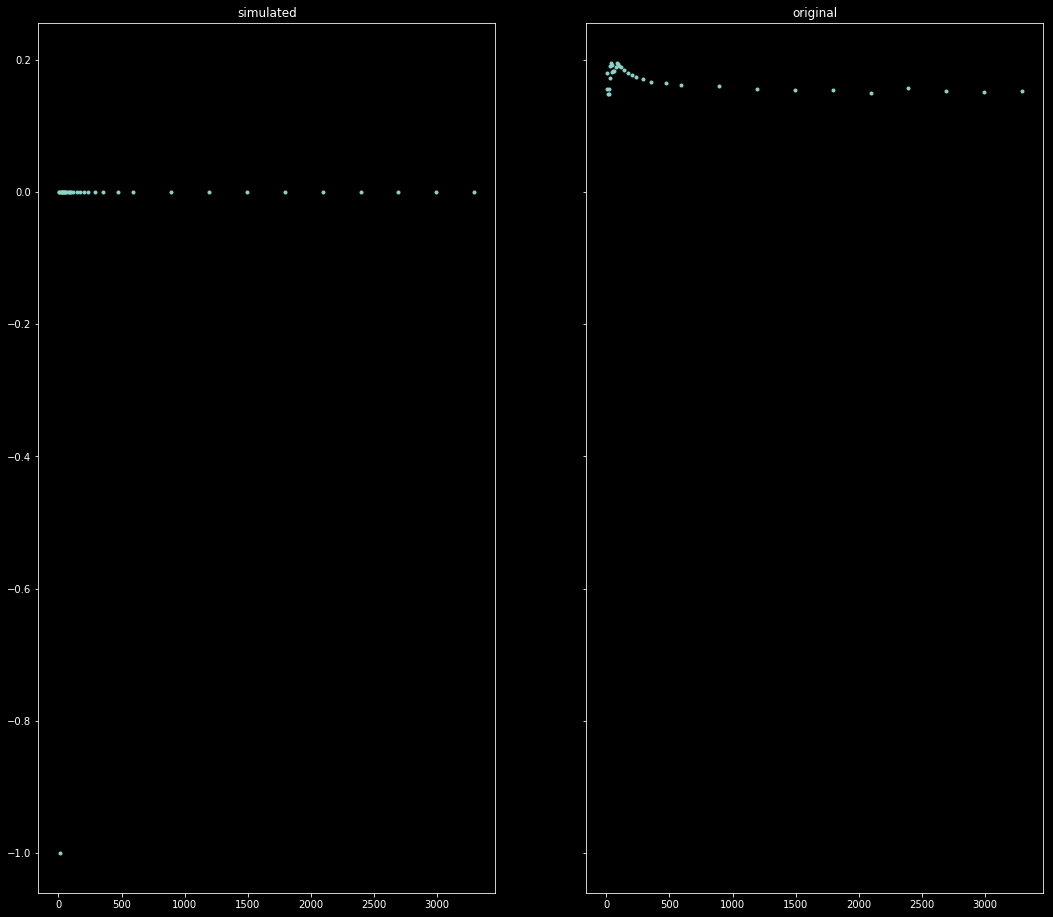

In [107]:
x = 1
begin_off = 2

fulldf = pd.concat([pd.DataFrame(X_s),tX],axis=1)

plt.figure(figsize=(12, 8))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 16), sharey=True)
sim_arr = X_s[begin_off:,x]
ax1.plot(t_span[begin_off:],sim_arr/np.linalg.norm(sim_arr),'.')
orig_arr = tXmat[begin_off:,x]
ax2.plot(t_span[begin_off:],orig_arr/np.linalg.norm(orig_arr),'.')
ax1.set_title('simulated')
ax2.set_title('original')
plt.show()


In [93]:
X_s.shape

(36, 4)

In [65]:
x = pd.DataFrame(np.array([2,3])).T
np.array(poolData(x,2,2,0))

array([[1., 2., 3., 4., 6., 9.]])

In [71]:
tX.iloc[0].values

array([19.71612054, 30.63586501])

In [45]:
def calc_error(x0,dynamic_fn,xdf):
    X_s = odeint(dynamic_fn,x0,t_span)
    

#### Show singular values

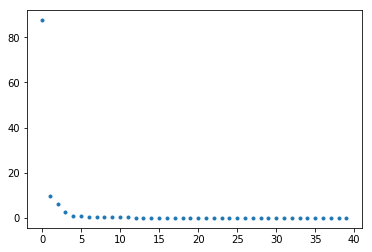

In [39]:
X = roi.reshape(128*60*40,40)
U,S,V = np.linalg.svd(X.T.dot(X))
plt.plot(np.arange(40),S,'.')

In [147]:
poolData(pd.DataFrame(np.array([2,3])).T,nVars, polyorder, usesine).values.T

array([[1.],
       [2.],
       [3.],
       [4.],
       [6.],
       [9.]])

In [130]:
tX_dot.as_matrix()/my_img.params.frame_duration[:-1,np.newaxis]

ValueError: Unable to coerce to DataFrame, shape must be (39, 2): given (39, 1)

In [131]:
tX_dot.div(my_img.params.frame_duration[:-1],axis=0)

,10,19
1,1.034653,0.364129
2,3.629686,2.014547
3,2.154414,1.829938
4,0.931990,0.639883
5,0.572269,0.388935
6,1.413963,0.764238
7,-1.901540,-0.964908
8,0.027860,0.065902
9,0.266675,0.220240
10,0.268017,0.180710


In [182]:
Theta.shape

(39, 6)

In [201]:
tX.loc[:,'x1']*tX.loc[:,'x2']

1       3.390721
2      53.075592
3     128.841451
4     166.372105
5     191.640713
6     253.639479
7     174.366435
8     181.370955
9     215.745496
10    249.285840
11    278.458412
12    287.296389
13    297.453075
14    306.000055
15    373.096455
16    374.680176
17    428.094831
18    507.273602
19    541.010425
20    570.103935
21    586.484493
22    571.589121
23    594.851524
24    621.735574
25    634.197375
26    633.868556
27    645.167491
28    662.314001
29    659.358945
30    661.909738
31    623.058524
32    588.679765
33    550.157615
34    501.251684
35    529.095901
36    485.002663
37    467.395454
38    466.809064
dtype: float64

In [211]:
Theta

,0,x1,x2,"(x1, x1)","(x1, x2)","(x2, x2)"
0,1.0,NaN,NaN,NaN,NaN,NaN
1,1.0,3.103959,1.092386,9.634561,3.390721,1.193307
2,1.0,10.363330,5.121480,107.398618,53.075592,26.229560
3,1.0,14.672159,8.781356,215.272247,128.841451,77.112214
4,1.0,16.536139,10.061122,273.443893,166.372105,101.226167
5,1.0,17.680677,10.838992,312.606334,191.640713,117.483745
6,1.0,20.508603,12.367467,420.602799,253.639479,152.954249
7,1.0,16.705524,10.437651,279.074523,174.366435,108.944569
8,1.0,16.844822,10.767163,283.748035,181.370955,115.931810
9,1.0,18.178198,11.868365,330.446891,215.745496,140.858093


In [215]:
len(np.ones(38))

38

In [217]:
tX.reset_index()

,index,x1,x2
0,1,3.103959,1.092386
1,2,10.363330,5.121480
2,3,14.672159,8.781356
3,4,16.536139,10.061122
4,5,17.680677,10.838992
5,6,20.508603,12.367467
6,7,16.705524,10.437651
7,8,16.844822,10.767163
8,9,18.178198,11.868365
9,10,19.518282,12.771915


In [226]:
tX.reset_index().reset_index()

,level_0,index,x1,x2,x3
0,0,0,1,3.103959,1.092386
1,1,1,2,10.363330,5.121480
2,2,2,3,14.672159,8.781356
3,3,3,4,16.536139,10.061122
4,4,4,5,17.680677,10.838992
5,5,5,6,20.508603,12.367467
6,6,6,7,16.705524,10.437651
7,7,7,8,16.844822,10.767163
8,8,8,9,18.178198,11.868365
9,9,9,10,19.518282,12.771915
